### This notebook includes the entire pipeline for the analysis after the necessary preprocessing that creates a (2040, 2639) feature matrix. At a high level, this notebook tunes a given classifier for predicting whether a speech recording is indicative of a speech disorder (0: Benign, 1: Anomalous). Then, the tuned classifier is used to predict instances within the test (hold out) set. ROC curves, Precision, Recall, and F-1 scores are also calculated outside of accuracy. Lastly, we interpret the constructed model through permutation importance, shapley importance, and partial dependency plots.

### Note: The results of the RCEFV with a simple random forests classifier are not shown here (a simple subset is created based on the results in the second code cell), although the process was a straightforward recursive feature elimination using a random forests model with default hyperparameters and step size of 1. Additionally, feature pruning based on correlation is conducted only to better improve interpretability (e.g., permutation feature importance is heavily influenced by highly correlated features). This additional reduction of features based on collinearity allows for better interpretability of the model at the cost of a slight predictive capability decrease.

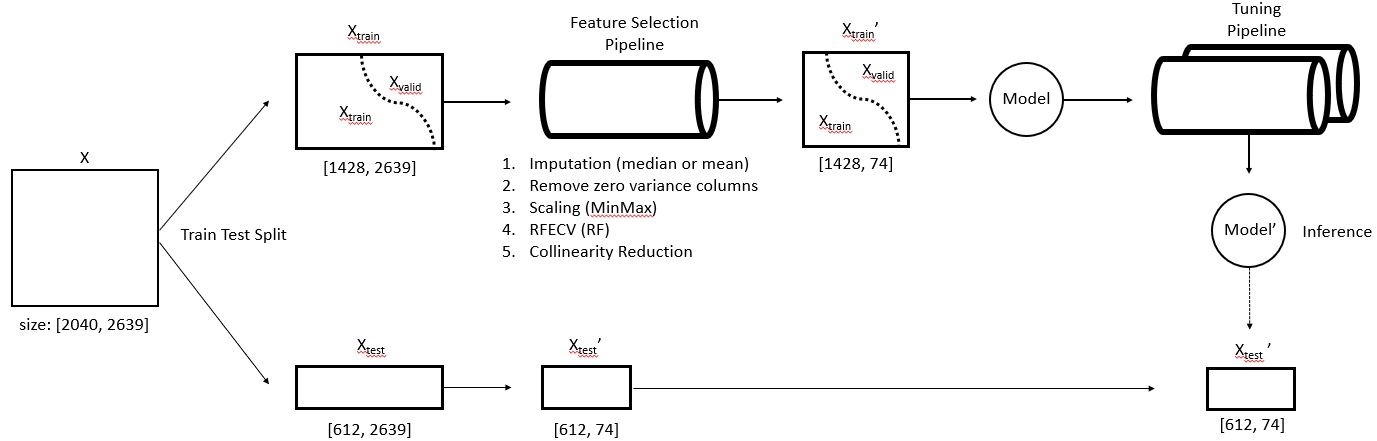

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, RFECV
from sklearn.metrics import accuracy_score, classification_report
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from pylab import rcParams
from sklearn.impute import KNNImputer
import pickle
from sklearn.metrics import roc_auc_score

rcParams['figure.figsize'] = 10, 10
rcParams['figure.dpi'] = 300
rcParams['font.size'] = 10

#### Read in data, and then subset based on RFECV results using a default RandomForestClassifier(). Import data and drop a few features.

In [3]:
X = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\Complete_Feature_Set_11_19_2.csv')
y, age, sex, recording_num = X['y'], X['age'], X['sex'], X['recording_num']
X = X.drop(['y','age','sex','recording_num'], axis = 1)
num_feats_prior = X.shape[1]

rfecv_subset = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\RFECV_Results_12_8.csv')
X = X.loc[:, rfecv_subset.columns]
num_feats_after = X.shape[1]
print('Total number of features dropped was... ', num_feats_prior - num_feats_after, '\nRemaining features... ', num_feats_after)

Total number of features dropped was...  2535 
Remaining features...  104


#### Assess correlation between features, and drop individual features if they correlate highly (r > .75 chosen here) with any other features.

In [4]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)] 
X = X.drop(X[to_drop], axis=1)
print('Total number of features dropped was...', num_feats_after - X.shape[1], '\nRemaining features... ', X.shape[1])

Total number of features dropped was... 29 
Remaining features...  75


In [5]:
X = X.drop('high_indexphrase_features', axis = 1)

In [6]:
X.columns = ['Stdev Period l-a', 'Stdev MFCC-7 l-a', 'Mean Slope Melspec l-a', 'Mean Harmonicity l-a', 'Jitter (loc) h-a',
'Mean Slope Melspec h-a', 'Jitter (rap) lhl-a', 'Mean MFCC-2 lhl-a', 'Mean MFCC-7 lhl-a', 
'Stdev MFCC-2 lhl-a', 'Stdev Onset Envelope lhl-a', 'Stdev Pitches lhl-a', 'Mean Frequency n-a',
'Mean MFCC-8 n-a', 'LPC-1 n-a', 'Mean Slope Melspec n-a', 'Spec Power 1000Hz .25s n-a',
'Jitter (loc) l-i', 'Shimmer (apq11) l-i', 'Mean Magnitudes l-i', 'Mean Chromagram-4 l-i', 'Stdev Chromagram-4 l-i',
'Mean Slope (Hz) l-i', 'Mean MFCC-6 h-i', 'Mean Magnitudes h-i', 'Mean Slope (Hz) h-i', 'Mean MFCC-9 lhl-i',
'Mean Magnitudes lhl-i', 'Mean Harmony lhl-i', 'Mean Chromagram-0 n-i', 'Mean Slope Melspec n-i', 'Stdev Period l-u',
'Mean MFCC-4 l-u', 'Mean Slope (Hz) l-u', 'Mean Slope Melspec h-u', 'Mean MFCC-4 lhl-u', 'Mean Onset Envelope lhl-u',
'Stdev MFCC Delta-5 lhl-u', 'Stdev MFCC Delta-10 lhl-u', 'Stdev Period n-u', 'Mean Slope (Hz) n-u', 'HNR Phrases',
'Count of Periods Phrases', 'Mean MFCC-2 Phrases', 'Mean MFCC Delta-3 Phrases', 'Mean MFCC Delta-4 Phrases', 
'Mean MFCC Delta-11 Phrases', 'Stdev MFCC-2 Phrases', 'Stdev Onset Envelope Phrases', 'Max RMS Phrases',
'Stdev MFCC Delta-3 Phrases', 'Stdev MFCC Delta-7 Phrases', 'Spec Power 1000Hz .25s Phrases',
'Spec Power 1000Hz .5s Phrases','Spec Power 1000Hz .75s Phrases', 'CPPS Phrases', 'LSF-0 l-a', 
'Spectral Flux Stdev lhl-a', 'Spectral Spread Mean lhl-a', 'Spectral Spread Mean n-i',
'Shannon Entropy Sliding Window First Deriv Stdev n-i', 'f2 l-i', 'Spectral Skewness Mean h-i', 'Crest Factor Mean n-u',
'Pitch Period Entropy l-u', 'Spectral Flux First Deriv Mean Phrases', 'Spectral Entropy First Deriv Stdev Phrases',
'Spectral Spread Mean Phrases', 'Spectral Skewness First Deriv Stdev Phrases', 'Spectral Flatness Stdev Phrases', 
'Spectral Rolloff Stdev Phrases', 'Pitch Period Entropy Phrases', 'LPC-4 Phrases', 'Kurtosis Sliding Window First Deriv Mean Phrases']

#### Split data and conduct an initial fit prior to hyperparameter tuning.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify = y, random_state = 42)

classifier = RandomForestClassifier()

test_pipeline = Pipeline([('variance_pruning', VarianceThreshold()),
                ('imputer', KNNImputer()), 
                ('scaler', MinMaxScaler()),
                ('model', classifier)])

test_pipeline.fit(X_train, y_train)
print(classification_report(y_test, test_pipeline.predict(X_test), target_names = ['benign','anomalous'], digits = 4))

              precision    recall  f1-score   support

      benign     0.7527    0.6650    0.7062       206
   anomalous     0.8395    0.8892    0.8636       406

    accuracy                         0.8137       612
   macro avg     0.7961    0.7771    0.7849       612
weighted avg     0.8103    0.8137    0.8106       612



#### Conducted hyperparameter tuning using RandomizedSearchCV and the already constructed pipeline. 

In [12]:
search_space = [{'model': [RandomForestClassifier()],
                 'model__criterion': ['gini', 'entropy'], # all
                 'model__n_estimators': [100, 300, 500, 1000],
                 'model__max_depth': [3, 5, 8],
                 'model__max_features': ['auto', 'sqrt', 'log2'],
                 'model__min_samples_split': [2, 5, 8],
                 'model__min_samples_leaf': [1, 5, 9]}]   

clf = RandomizedSearchCV(test_pipeline, search_space, cv = 5, verbose = 0, n_jobs = -1,\
                        scoring = 'roc_auc', n_iter = 50) 

clf = clf.fit(X_train, y_train) 

print('Best score of a given tuned classifier during the randomized search...', clf.best_score_*100)

Best score of a given tuned classifier during the randomized search... 88.09857308410392


#### Fetch best estimator found during the tuning process, and finally use this estimator to predict cases in the testing set. Calculate precision, recall, and f1-score across the two classes.

In [13]:
tuned_clf = clf.best_estimator_

print(classification_report(y_test, tuned_clf.predict(X_test), target_names = ['benign','anomalous'], digits = 4))
print(accuracy_score(y_test, tuned_clf.predict(X_test)))

              precision    recall  f1-score   support

      benign     0.7627    0.6553    0.7050       206
   anomalous     0.8368    0.8966    0.8656       406

    accuracy                         0.8154       612
   macro avg     0.7997    0.7759    0.7853       612
weighted avg     0.8118    0.8154    0.8116       612

0.815359477124183


In [14]:
print(clf.best_params_)

{'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 8, 'model__criterion': 'gini', 'model': RandomForestClassifier(max_depth=8, max_features='sqrt', n_estimators=300)}


#### Create a receiver operating characteristic (ROC) curve and derive area under the curve (AUC).

C:\Users\esabic\Anaconda3\envs\gpu_environment\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(*args, **kw)>

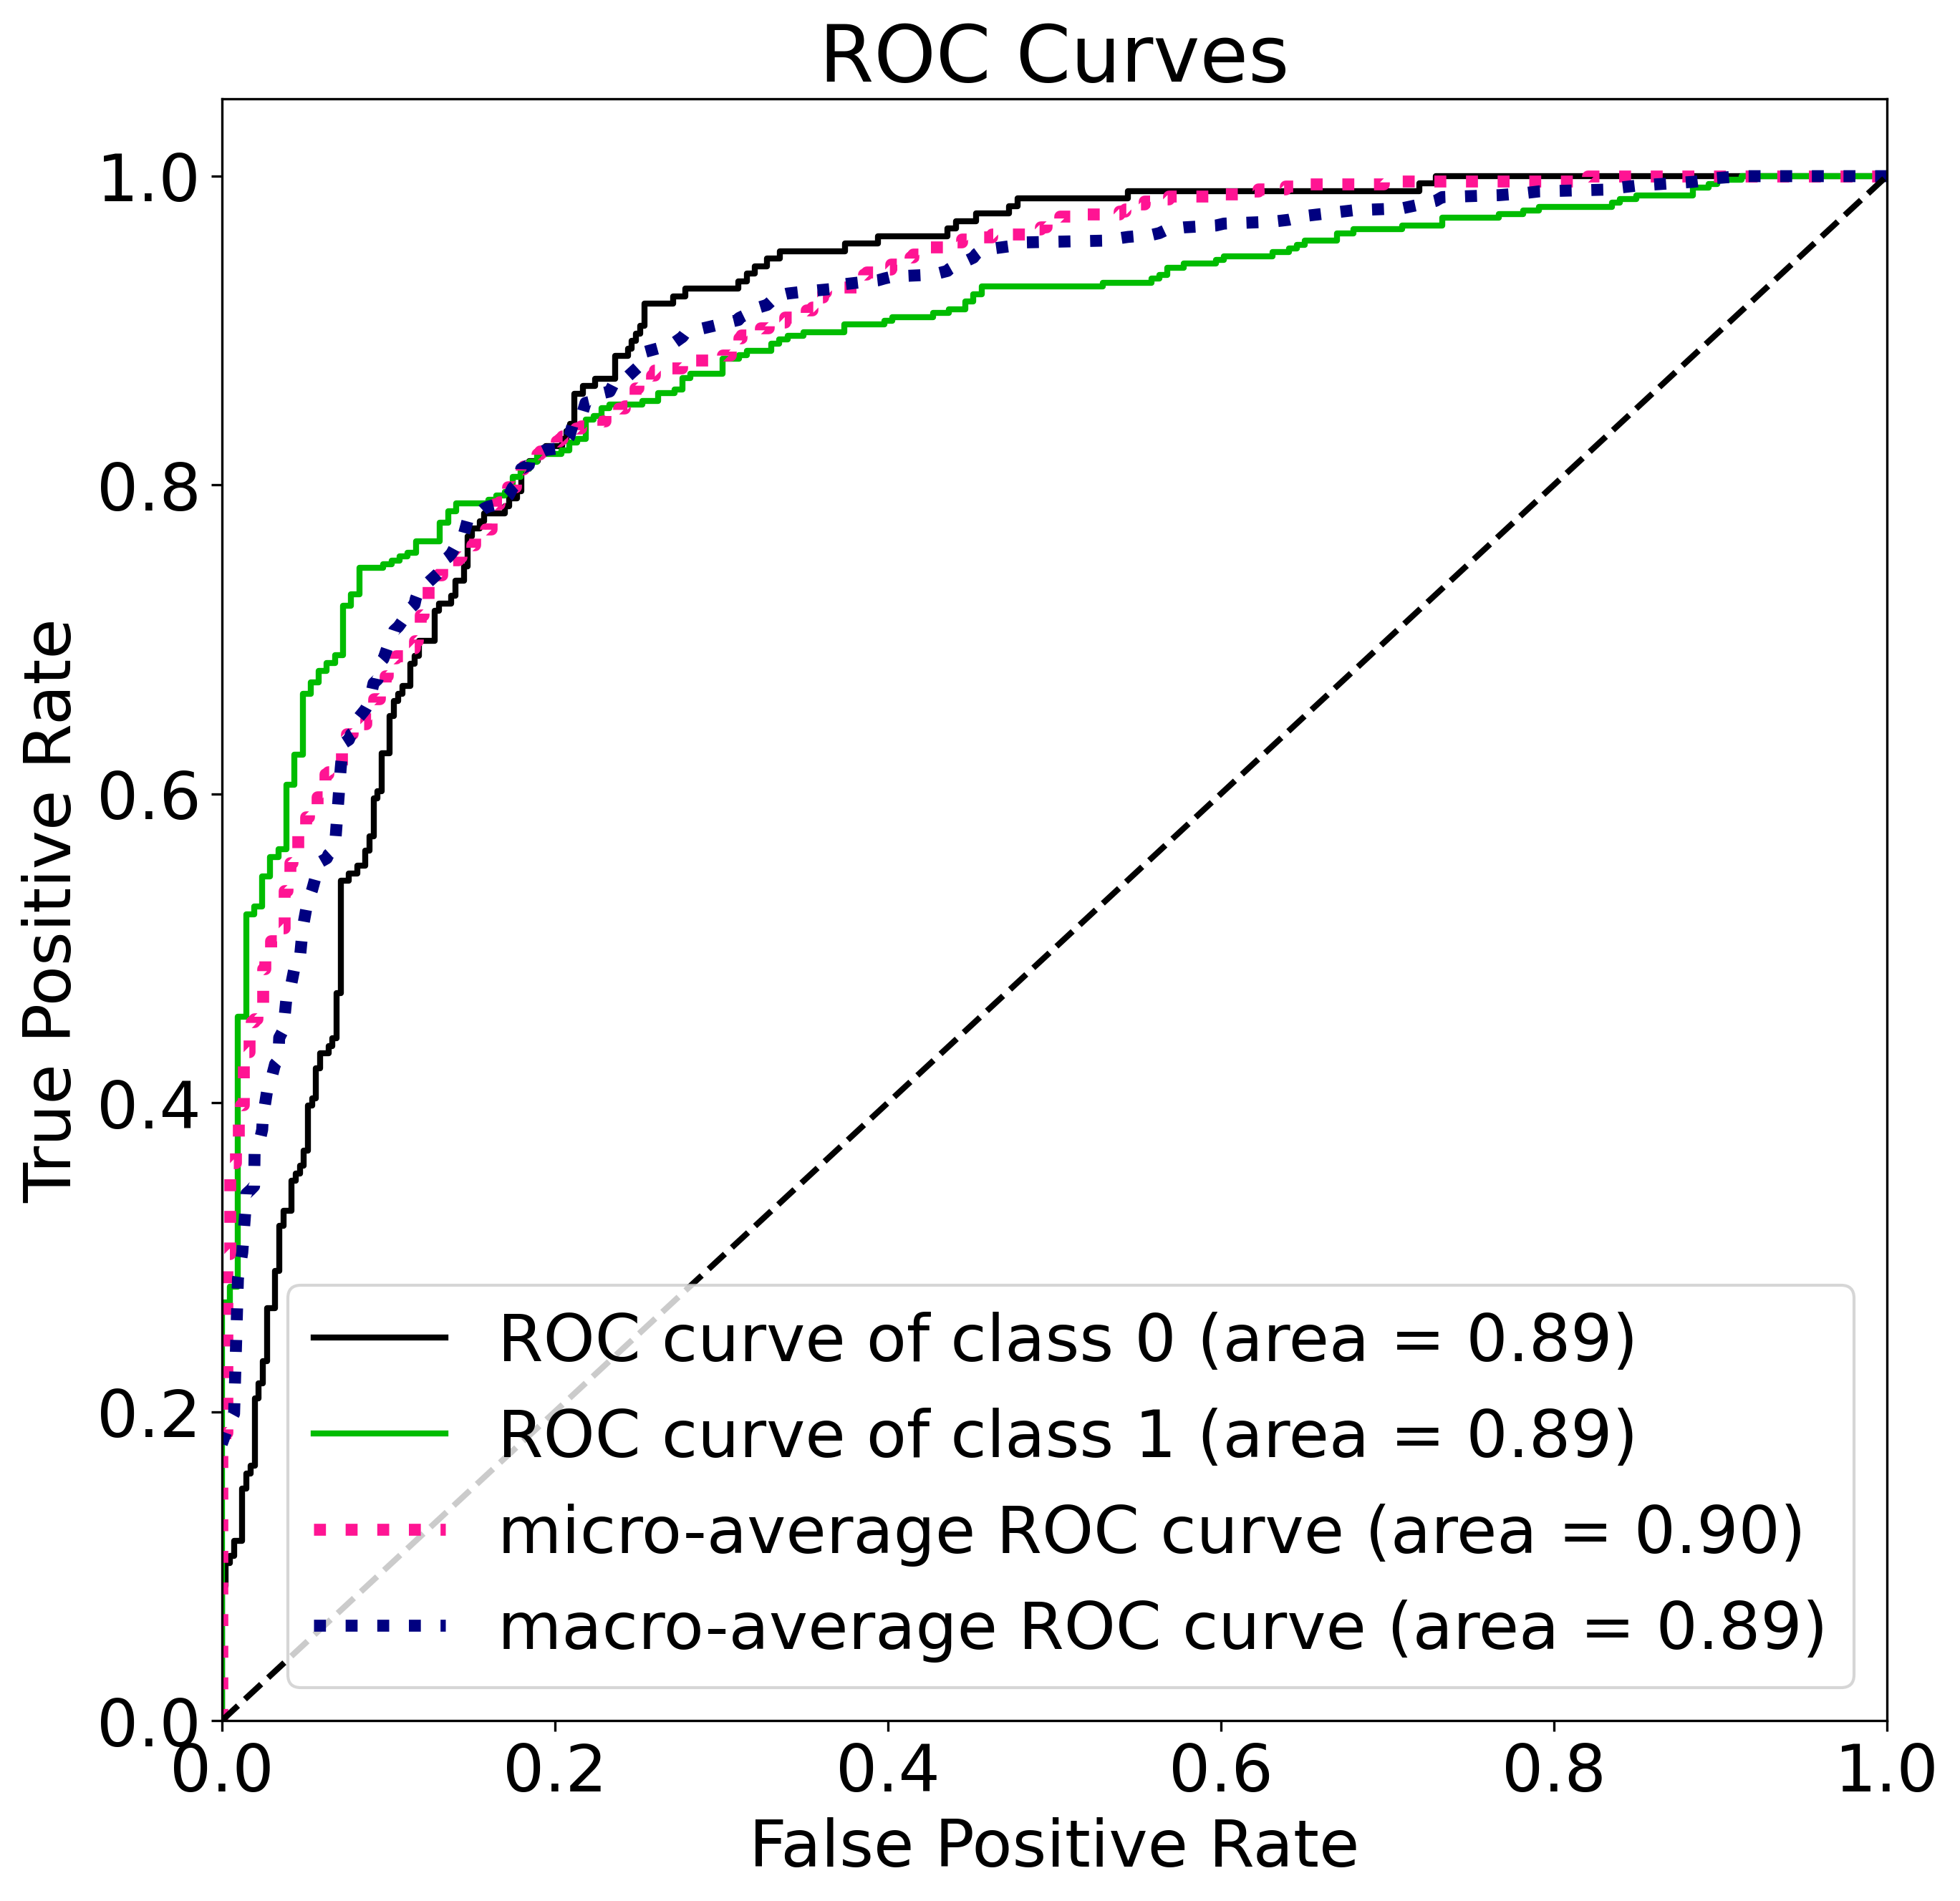

In [15]:
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt

rcParams['font.size'] = 22

y_true = y_test
y_probas = tuned_clf.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show

#### Conduct permutation importance, Shapley-based importance, and create partial dependency plots using the highly influential features.

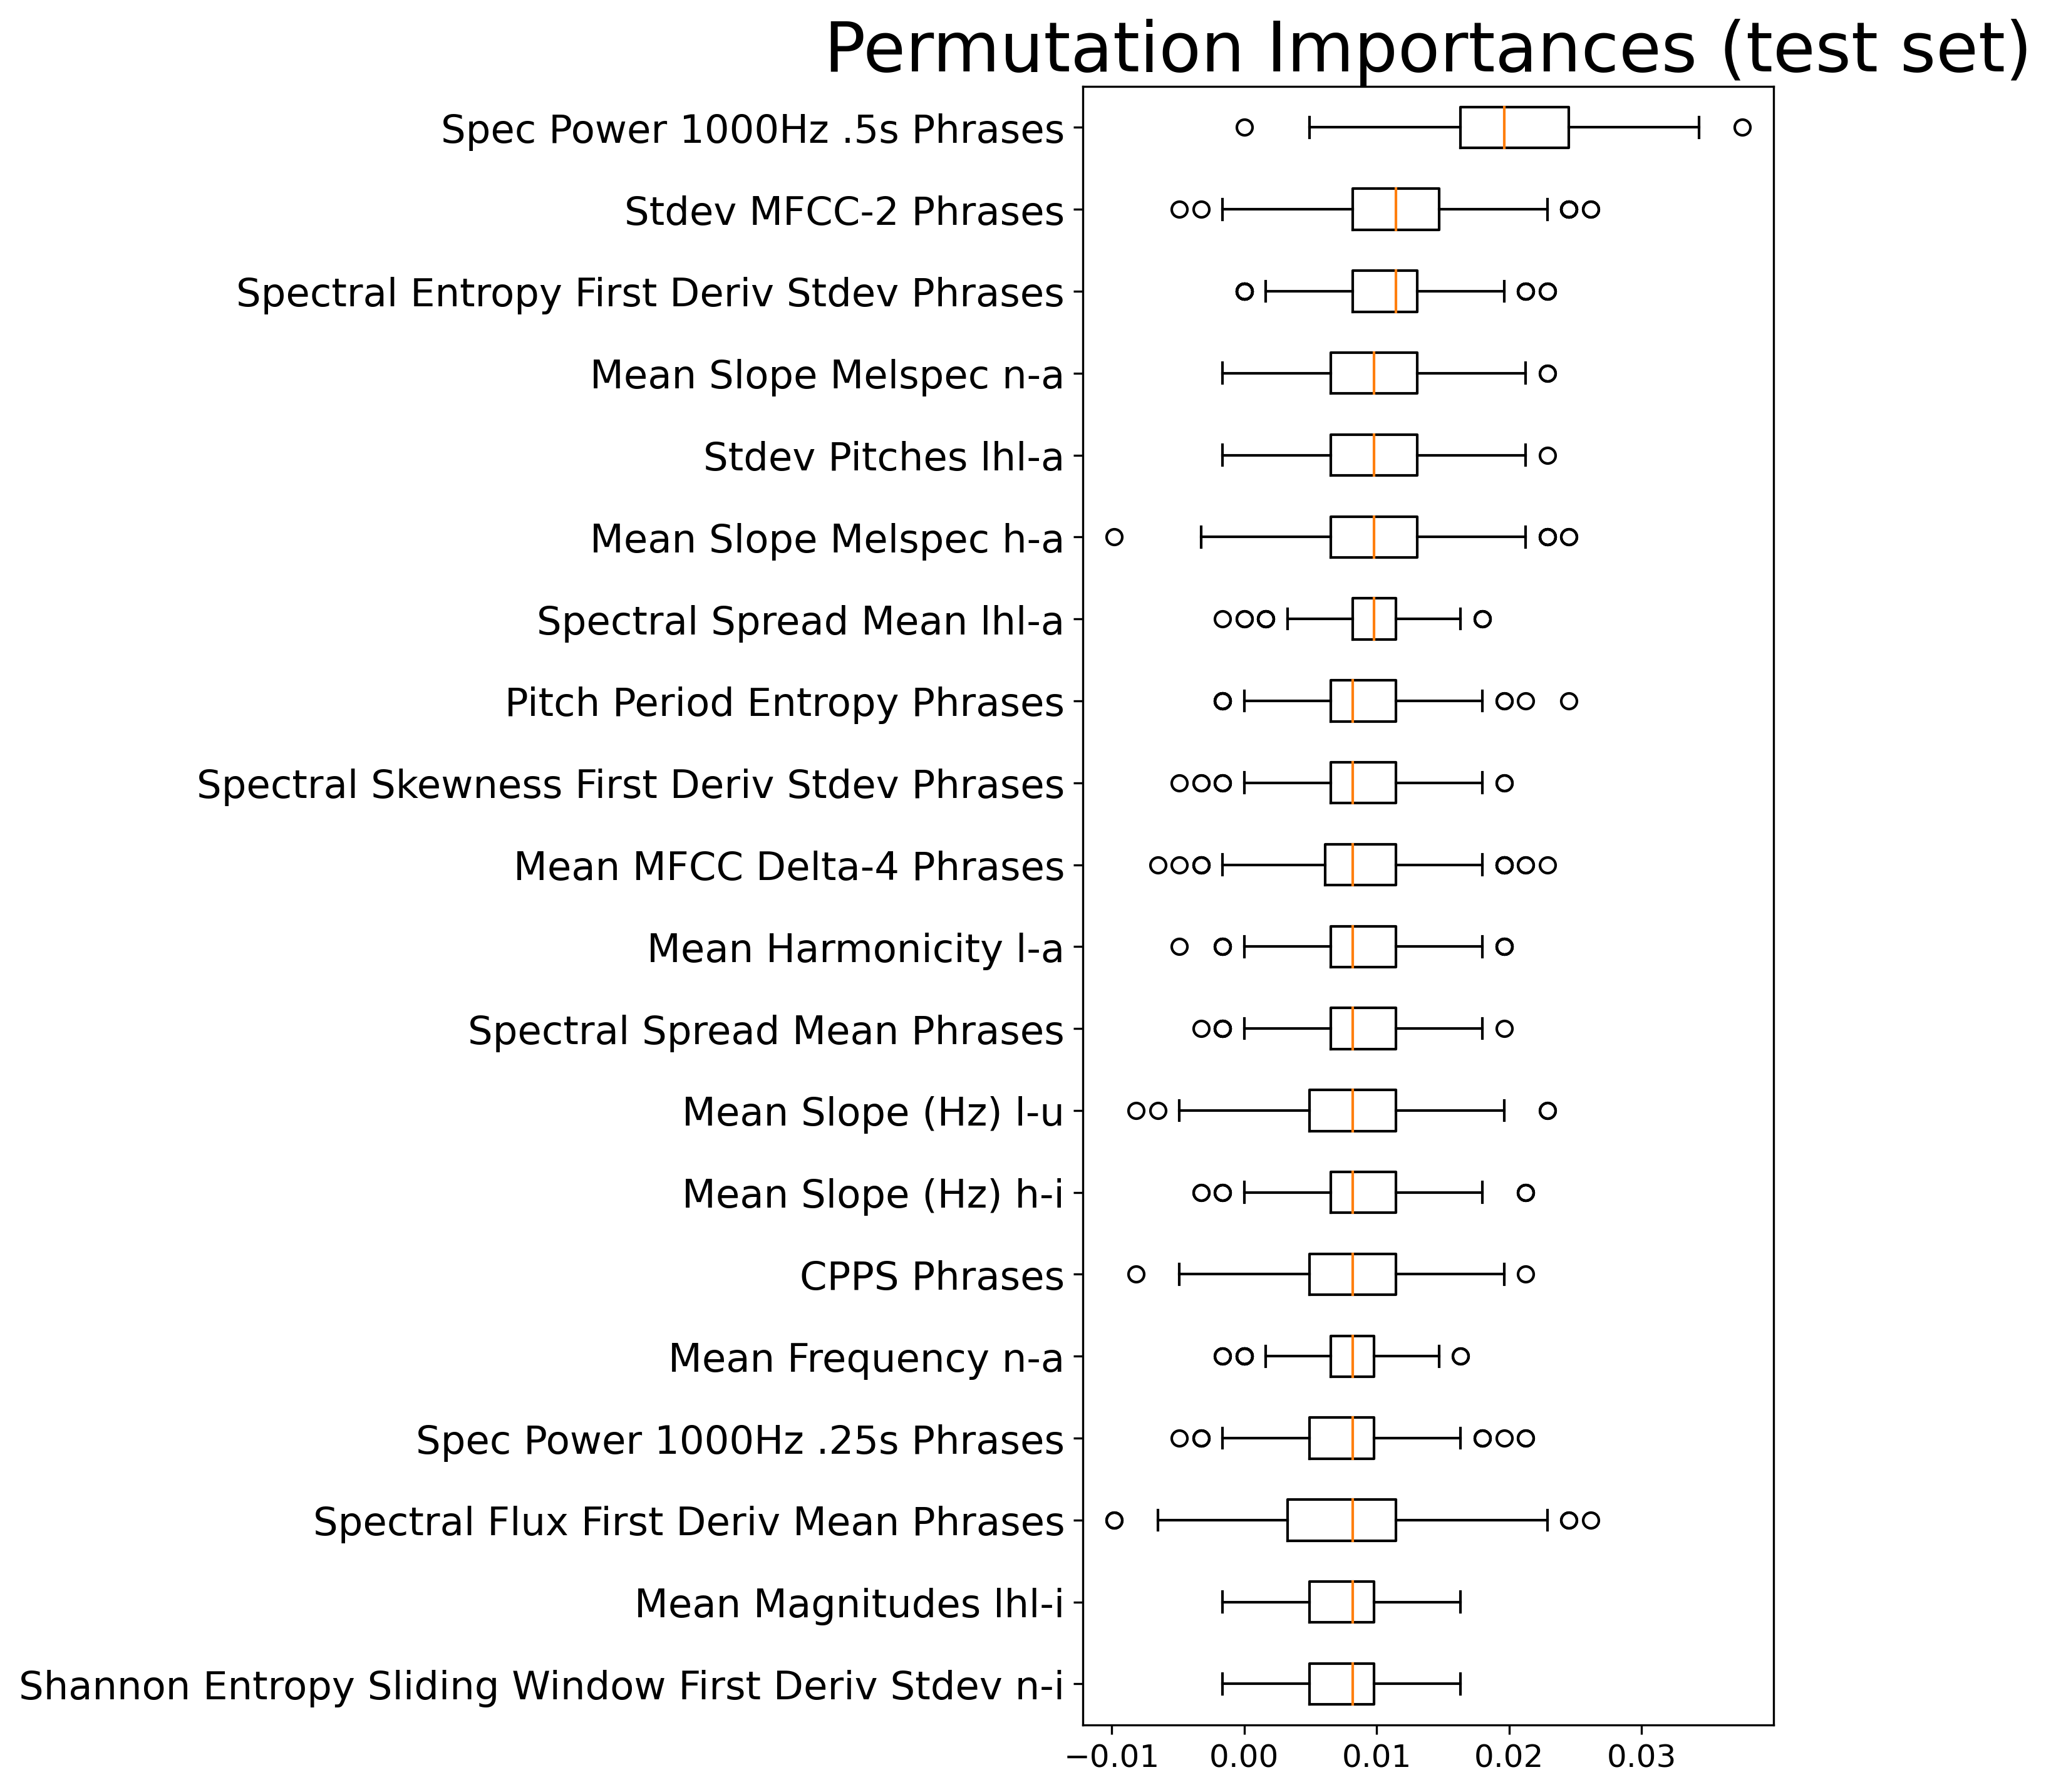

In [16]:
import matplotlib
from sklearn.inspection import permutation_importance

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=15) 

result = permutation_importance(tuned_clf, X_test, y_test, n_repeats = 500, 
                                random_state = 42, n_jobs = -1)

sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots()

ax.boxplot(result.importances[sorted_idx][-20:].T,
           vert=False, labels=X_test.columns[sorted_idx][-20:])

ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

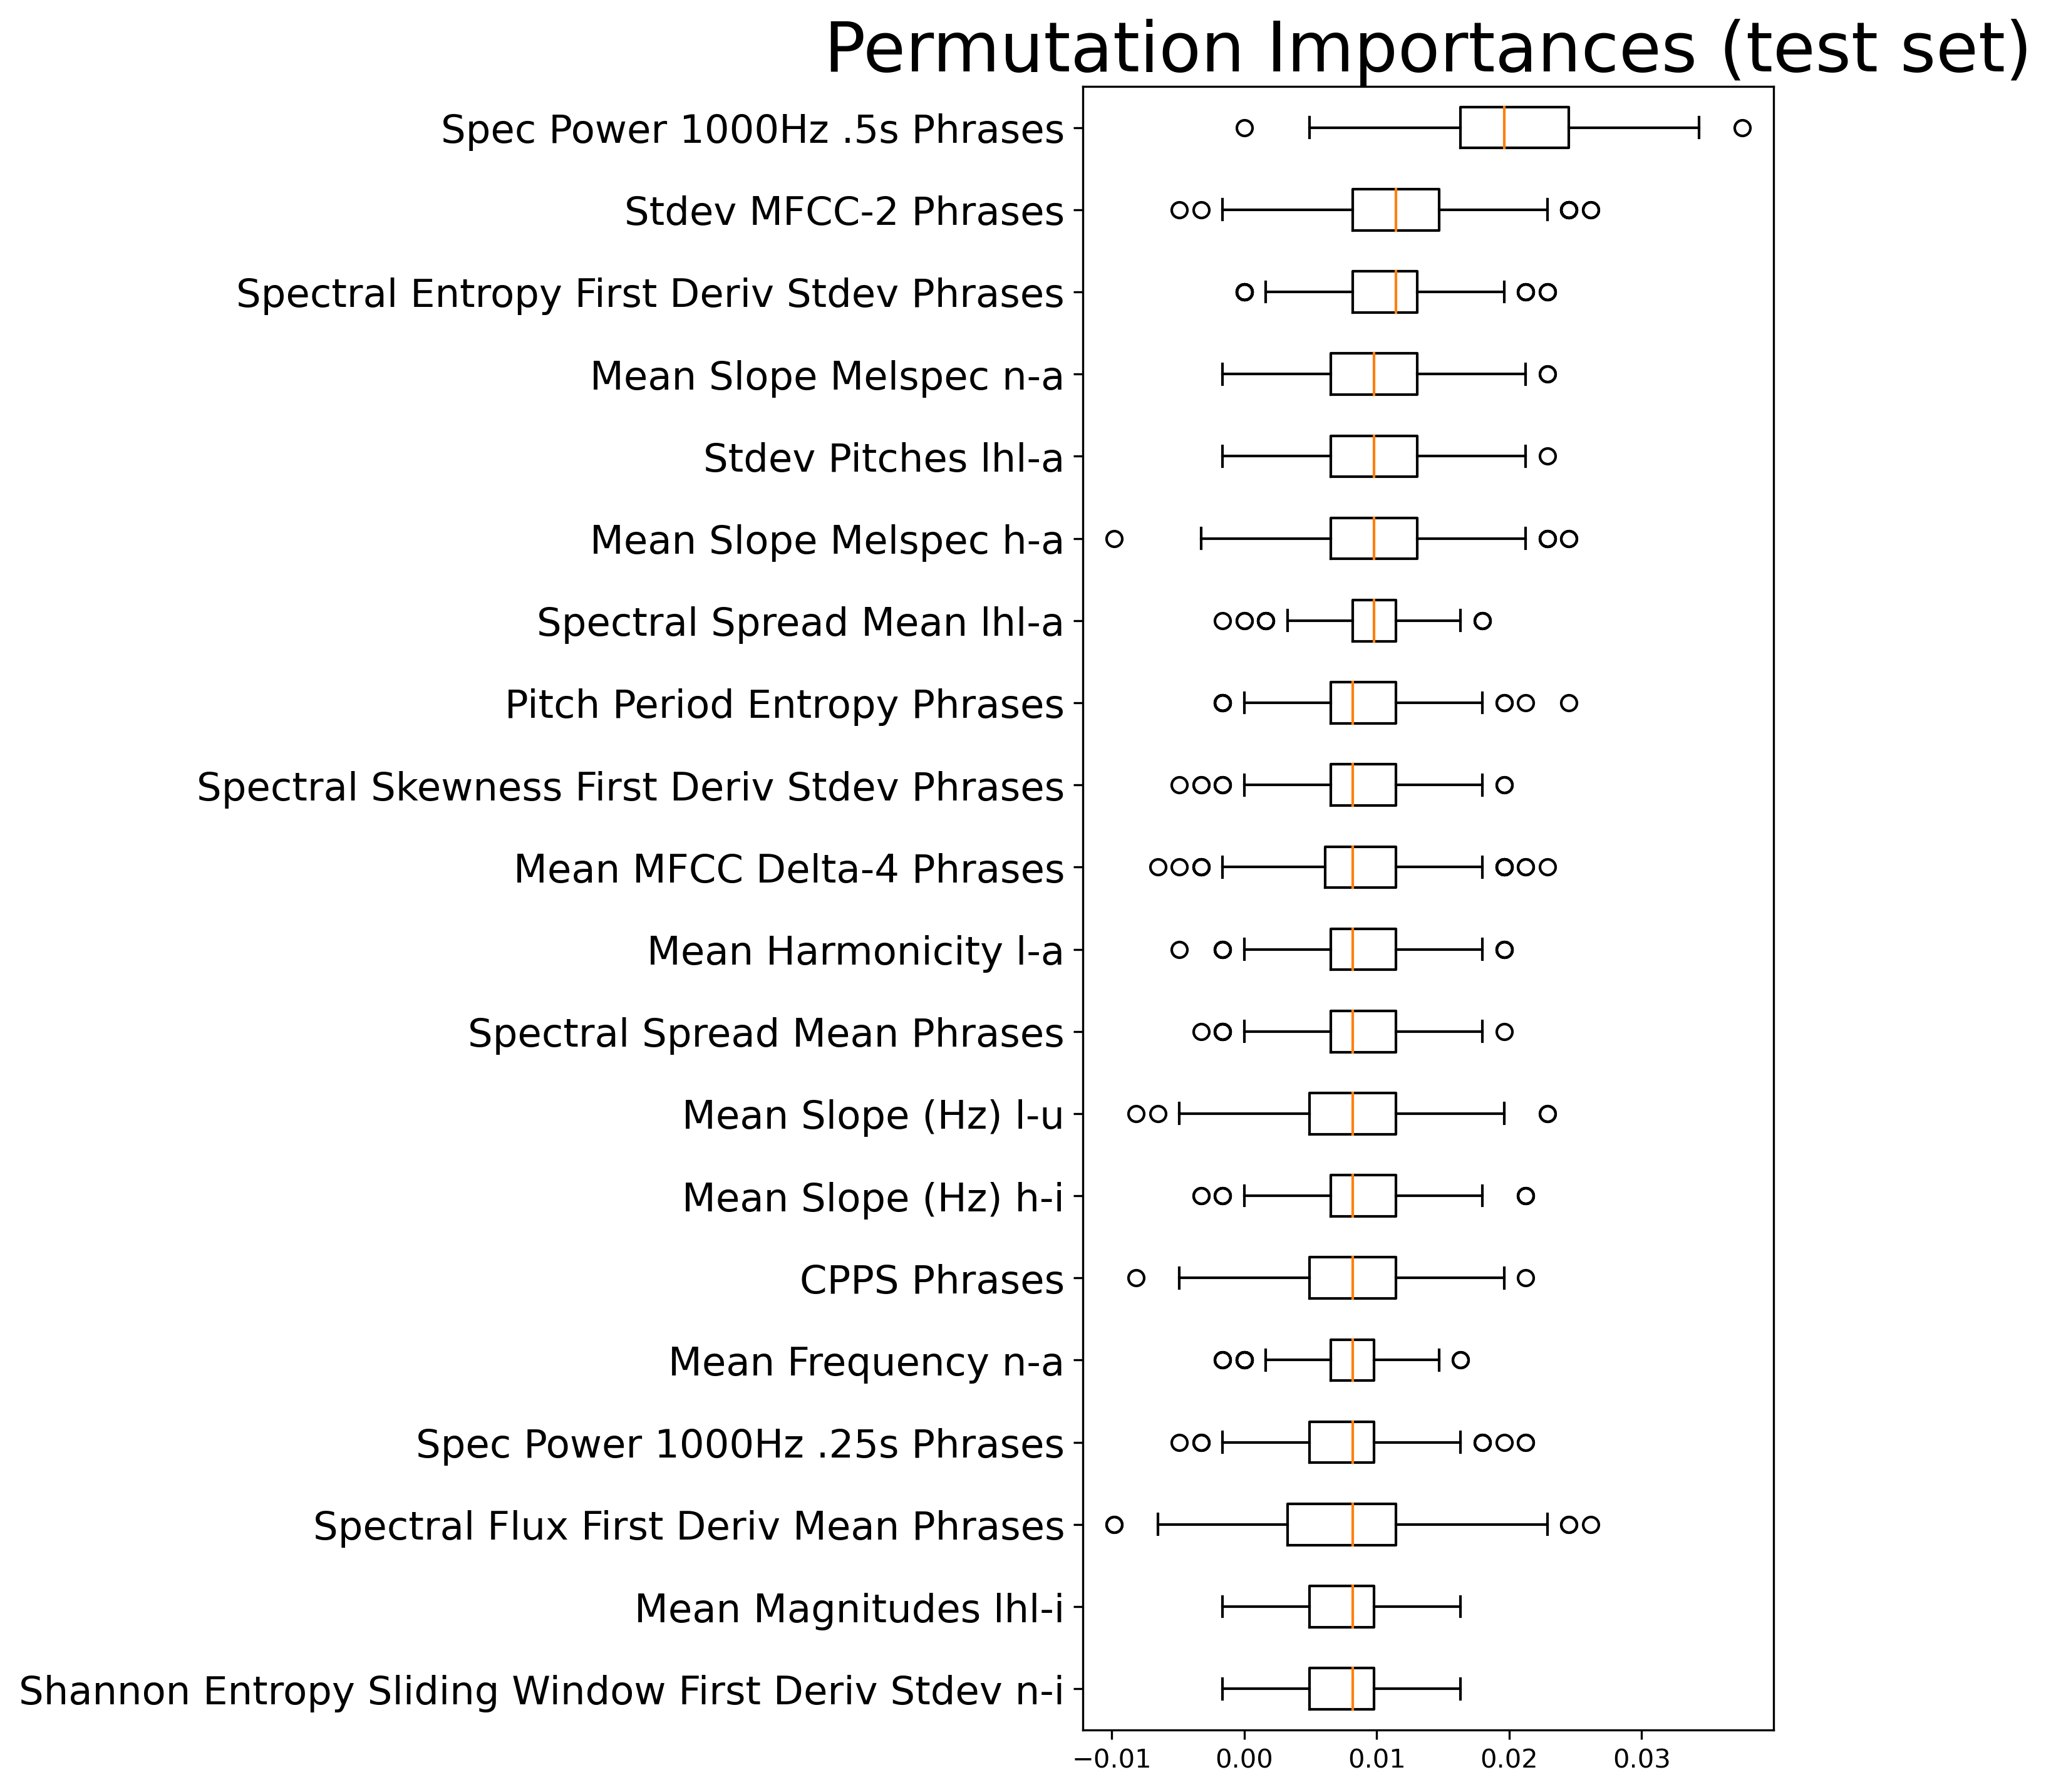

In [17]:
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=15) 

fig, ax = plt.subplots()

ax.boxplot(result.importances[sorted_idx][-20:].T,
           vert=False, labels=X_test.columns[sorted_idx][-20:])

ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Permutation explainer: 613it [03:01,  3.23it/s]                                                                        


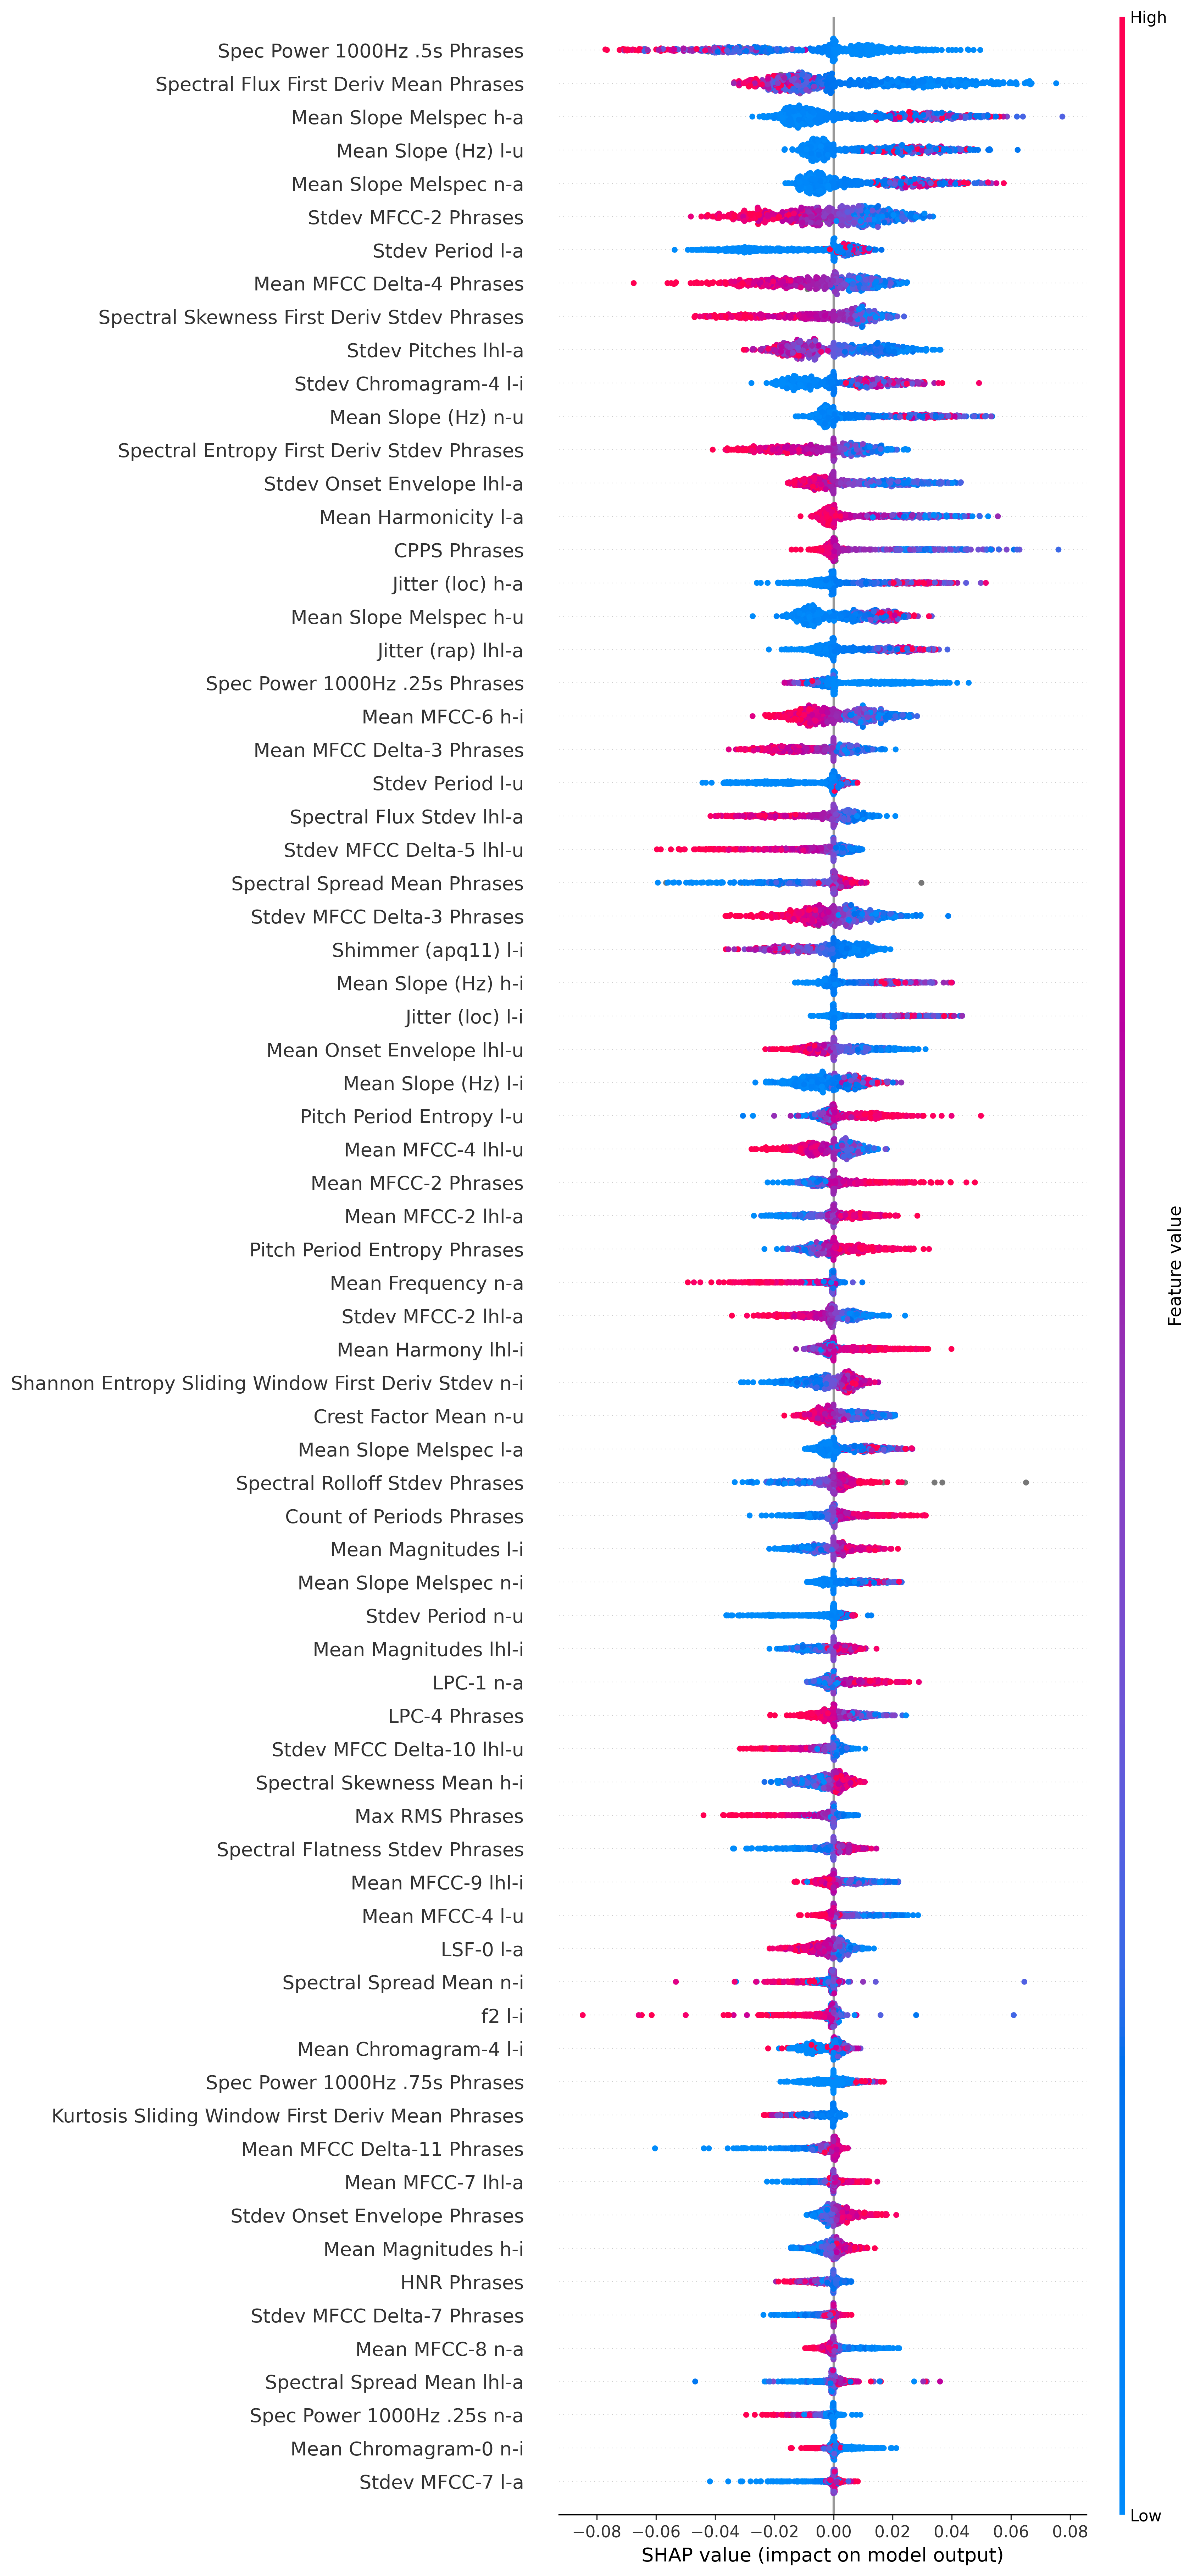

In [18]:
import shap

f = lambda x: tuned_clf.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test.iloc[:,:])

shap.plots.beeswarm(shap_values)

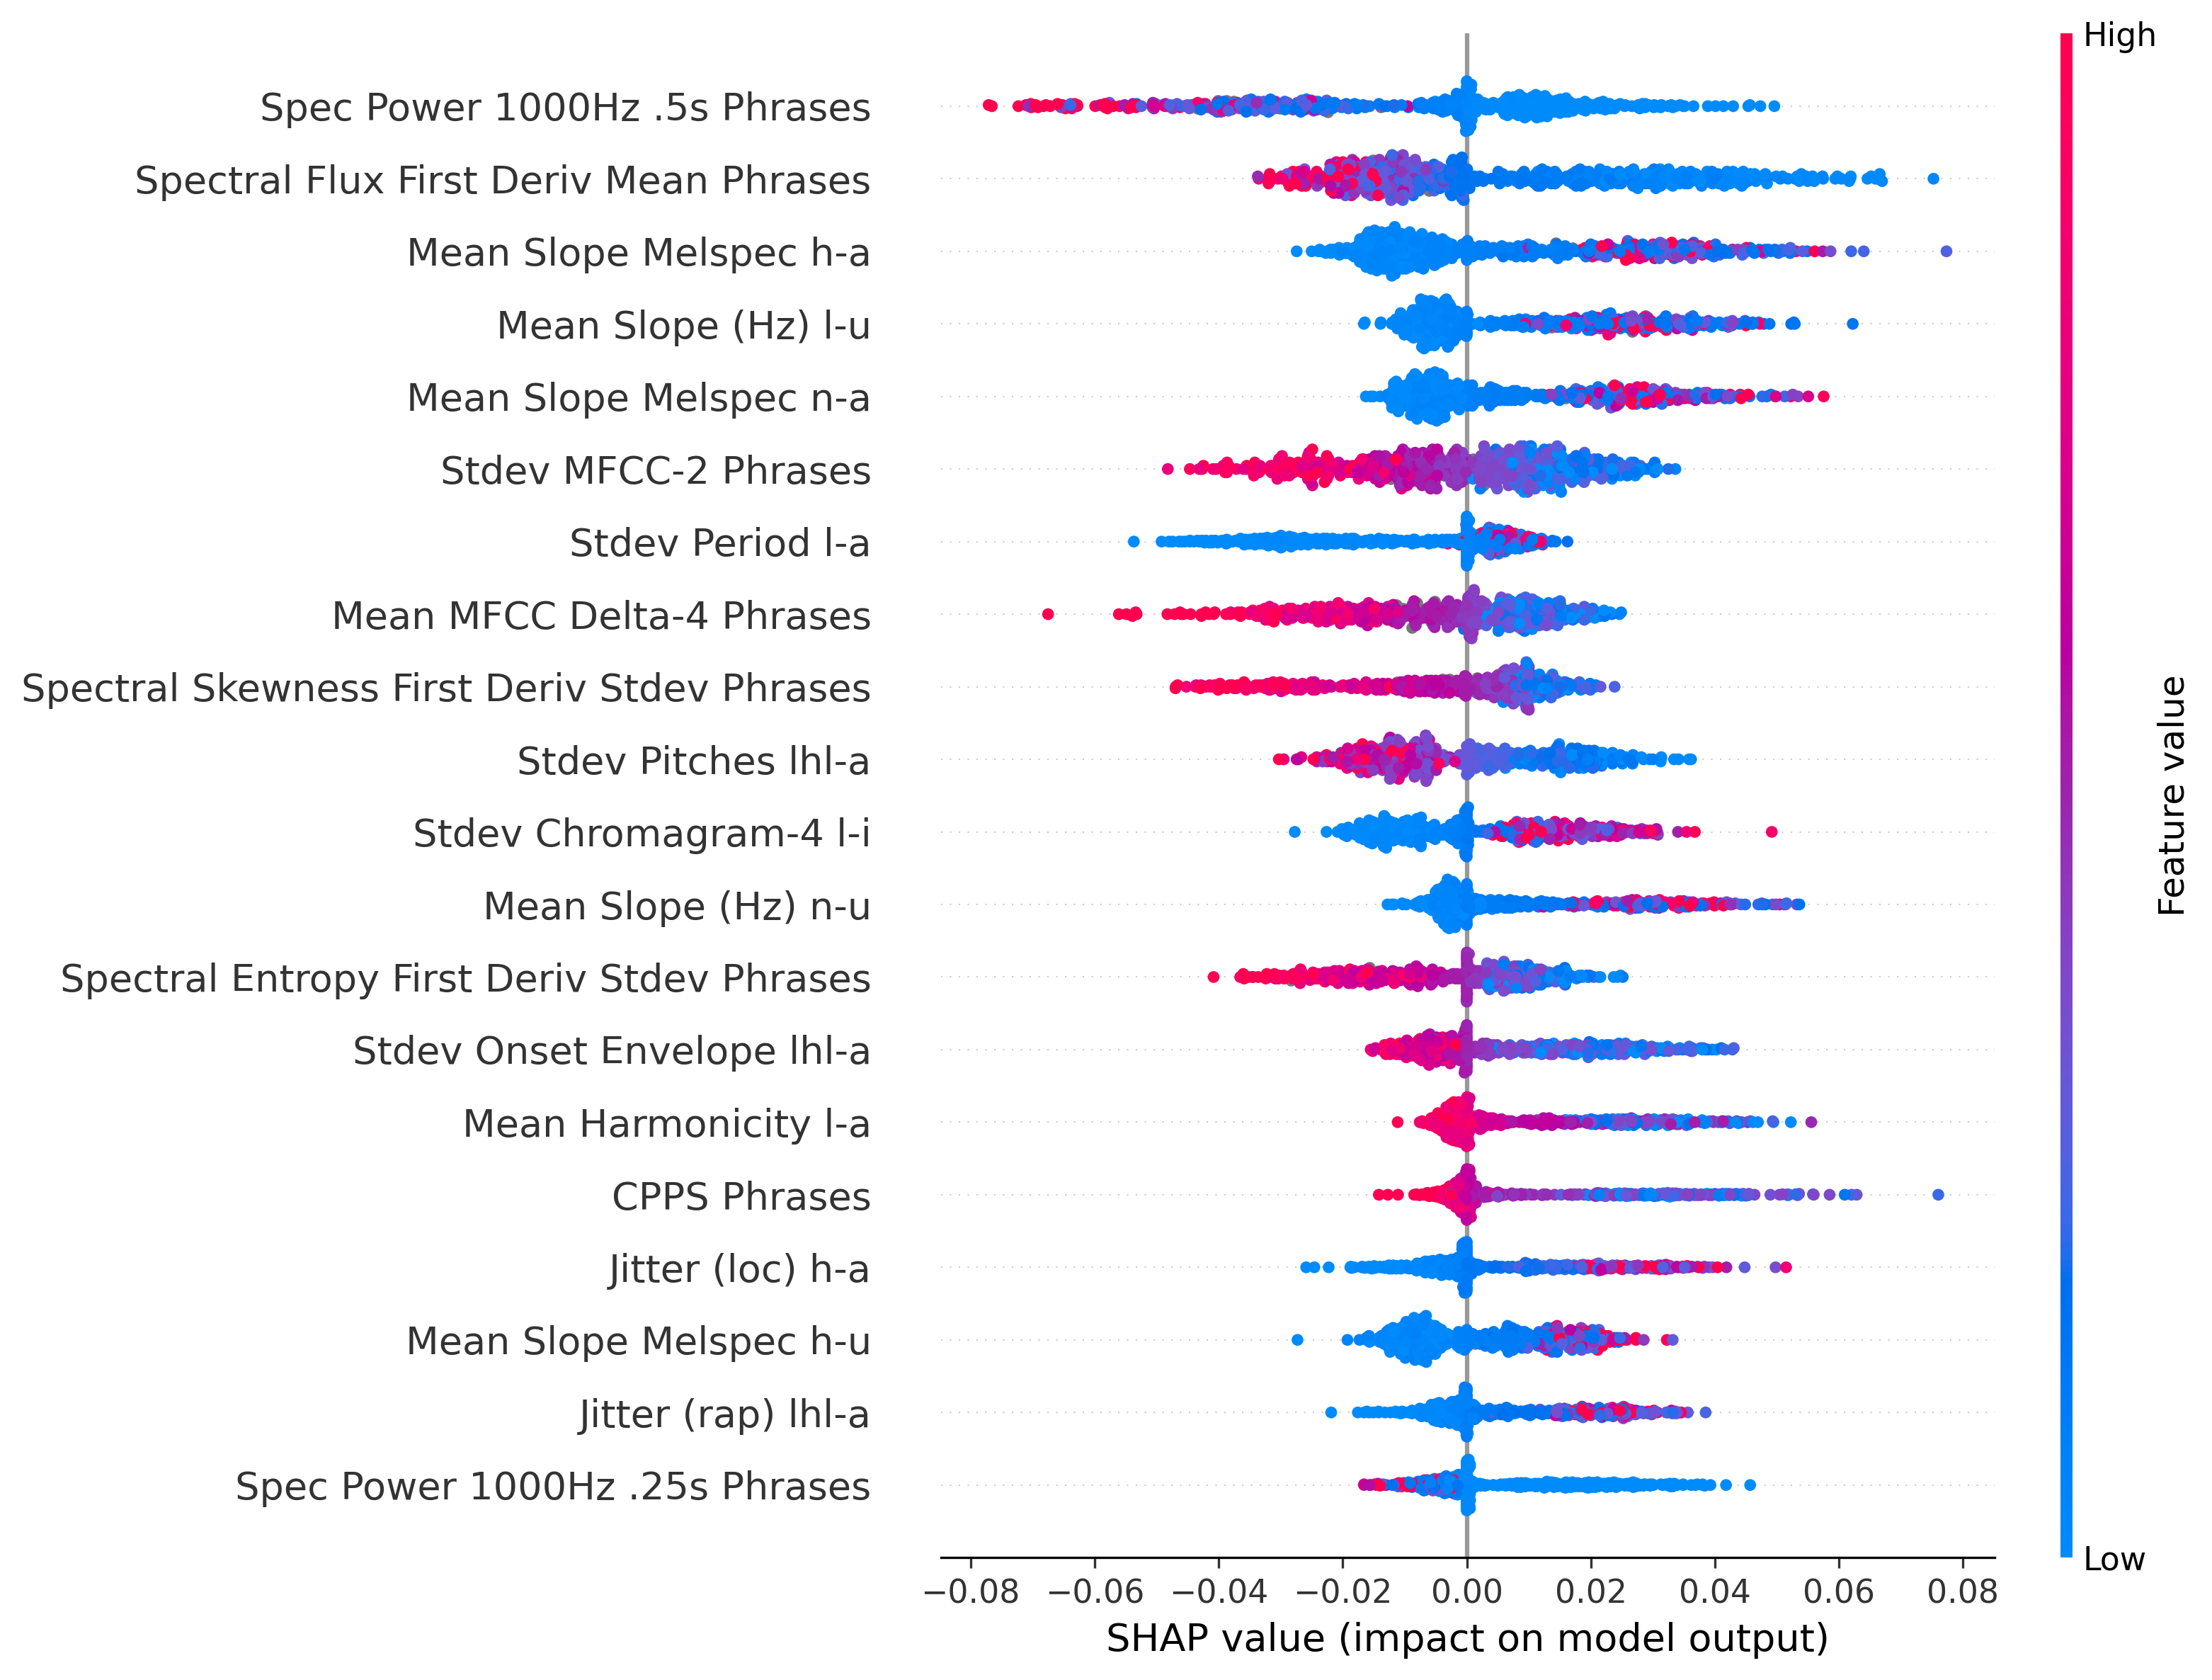

In [19]:
top = ['Spec Power 1000Hz .5s Phrases', 'Spectral Flux First Deriv Mean Phrases','Mean Slope Melspec h-a', 'Mean Slope (Hz) l-u',
      'Mean Slope Melspec n-a', 'Stdev MFCC-2 Phrases', 'Stdev Period l-a', 'Mean MFCC Delta-4 Phrases', 'Spectral Skewness First Deriv Stdev Phrases',
      'Stdev Pitches lhl-a', 'Stdev Chromagram-4 l-i', 'Mean Slope (Hz) n-u', 'Spectral Entropy First Deriv Stdev Phrases',
      'Stdev Onset Envelope lhl-a', 'Mean Harmonicity l-a', 'CPPS Phrases', 'Jitter (loc) h-a', 'Mean Slope Melspec h-u',
      'Jitter (rap) lhl-a', 'Spec Power 1000Hz .25s Phrases']

top_loc=[X.columns.get_loc(c) for c in top if c in X]
shap.plots.beeswarm(shap_values[:,top_loc])

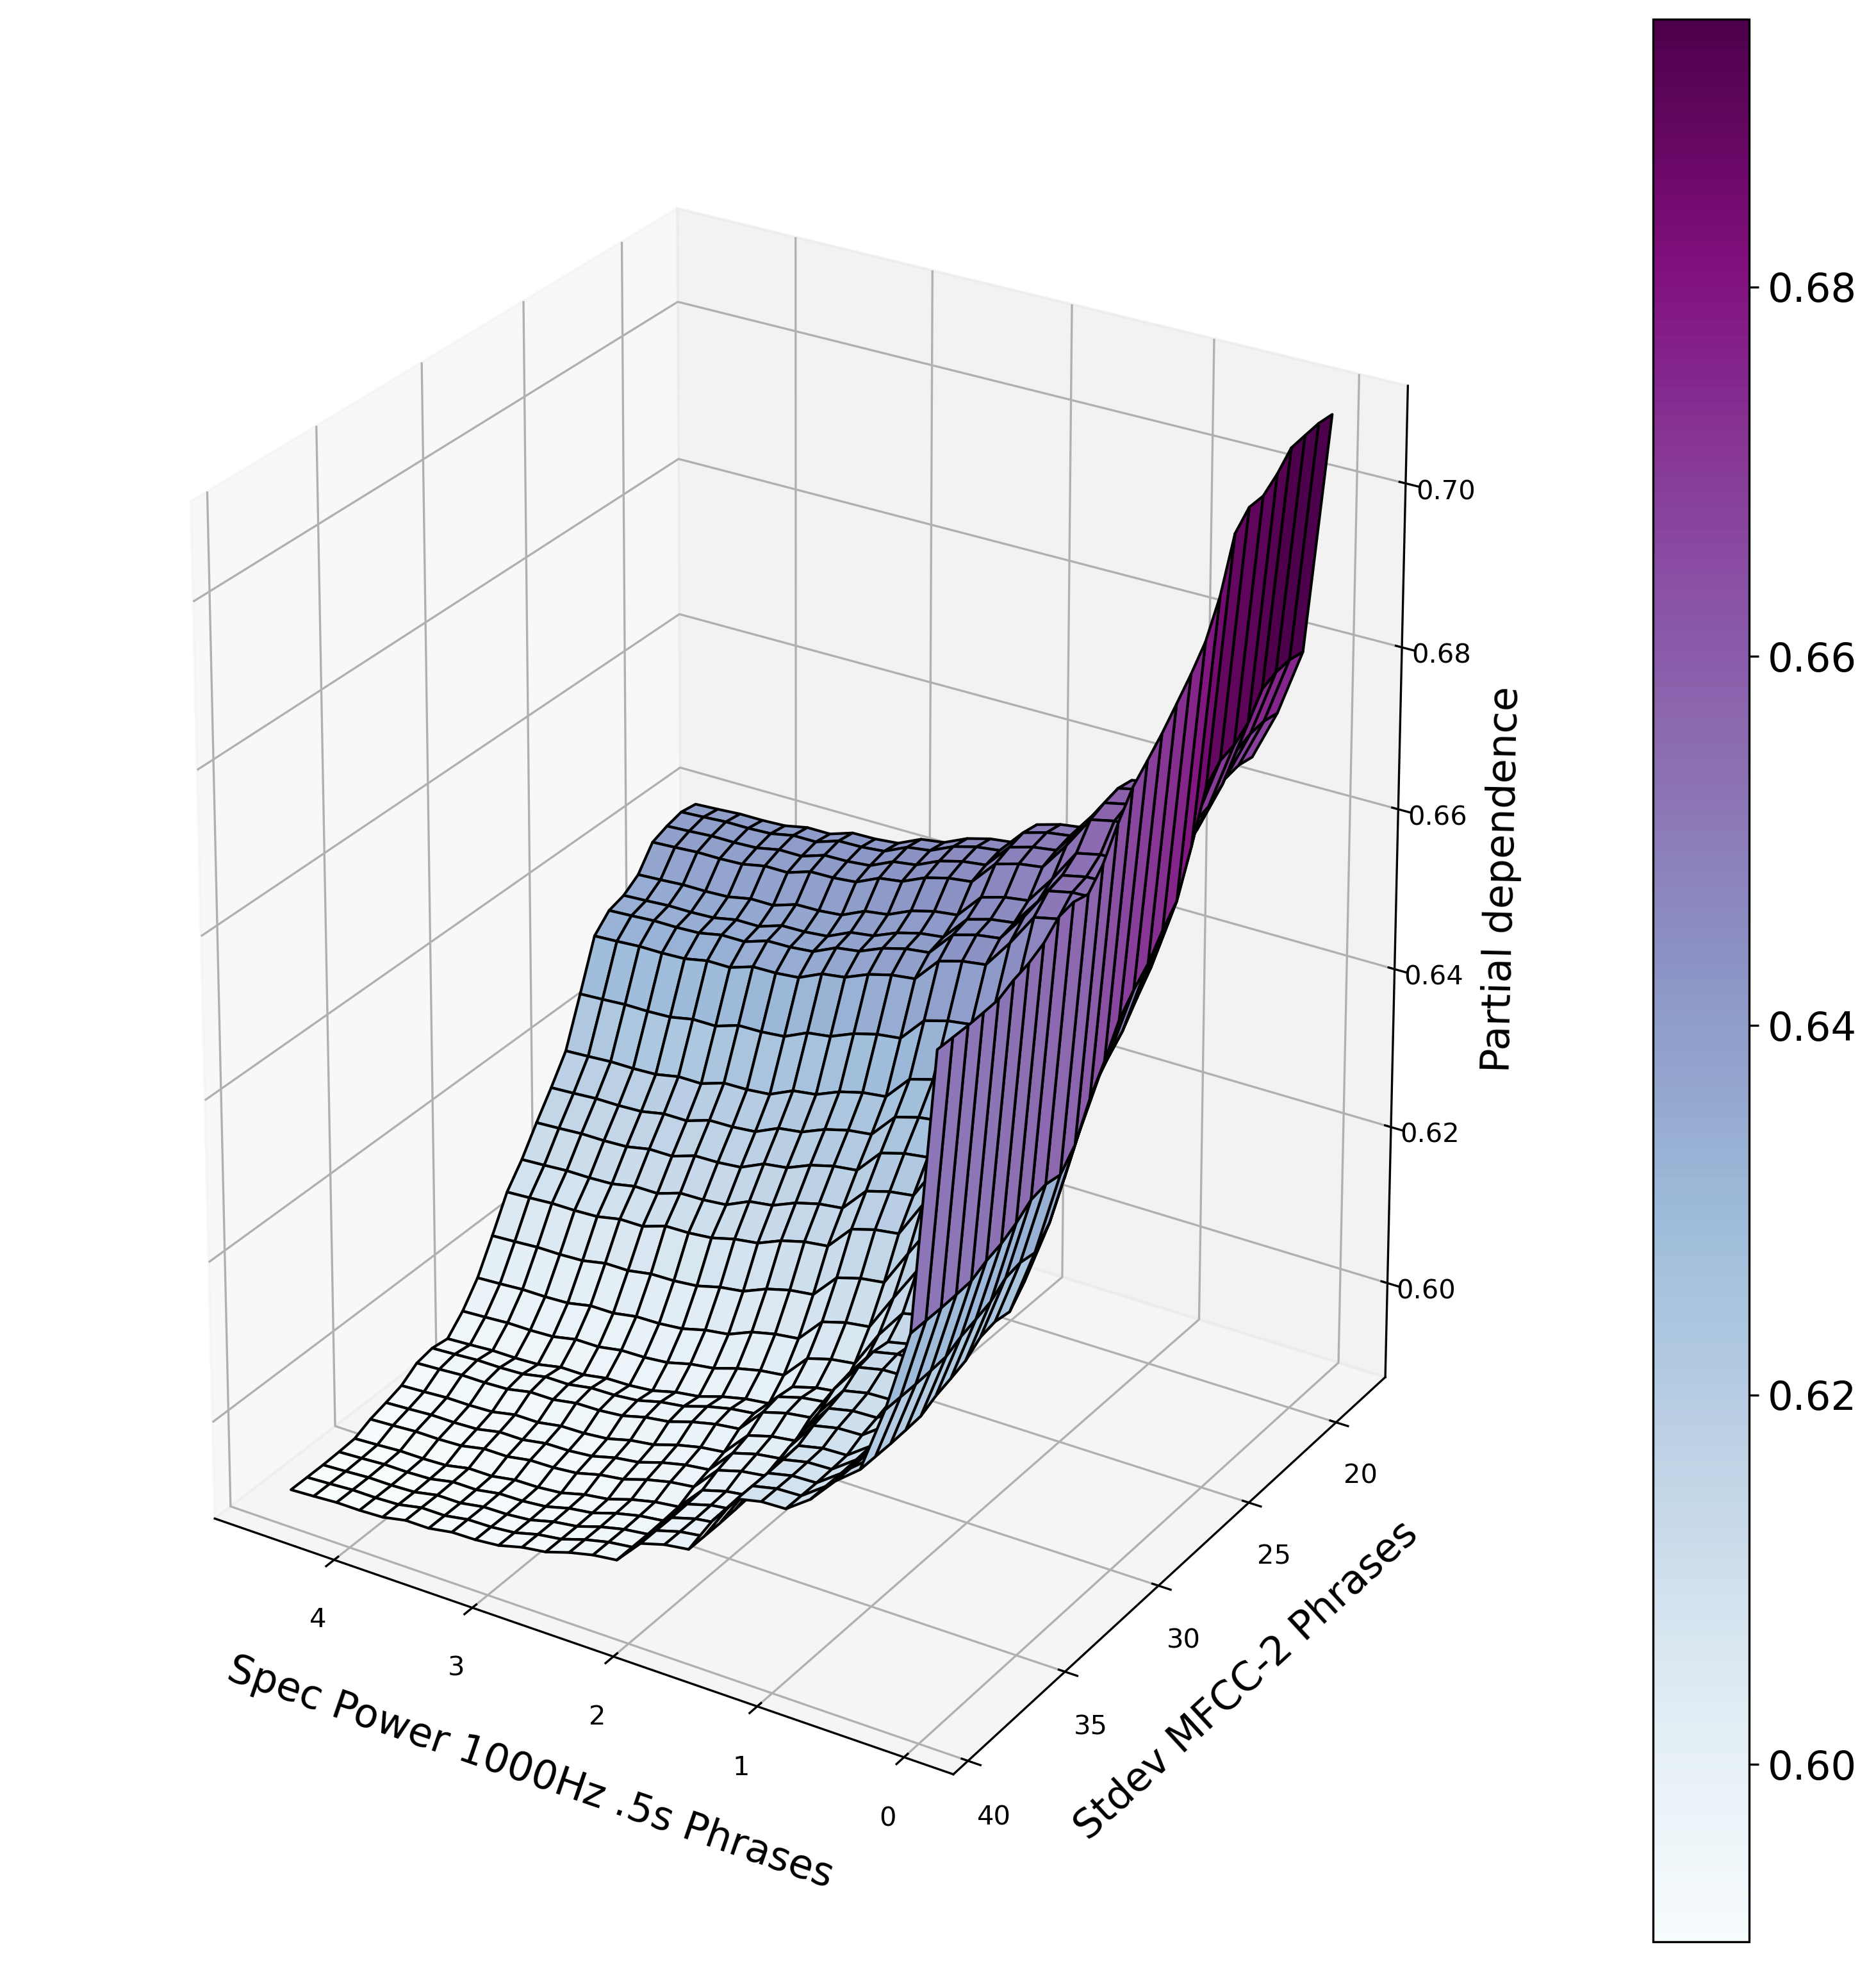

In [20]:
from sklearn.inspection import partial_dependence, plot_partial_dependence
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
rcParams['font.size'] = 15
fig = plt.figure()

features = ('Spec Power 1000Hz .5s Phrases', 'Stdev MFCC-2 Phrases')
pdp = partial_dependence(
    tuned_clf, X_test, kind = 'average', features=features, grid_resolution=28
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0], labelpad = 10)
ax.set_ylabel(features[1], labelpad = 10)
ax.set_zlabel('Partial dependence', labelpad = 10)

ax.view_init(elev=22, azim=122)
plt.colorbar(surf)

plt.subplots_adjust(top=0.9)
plt.show()

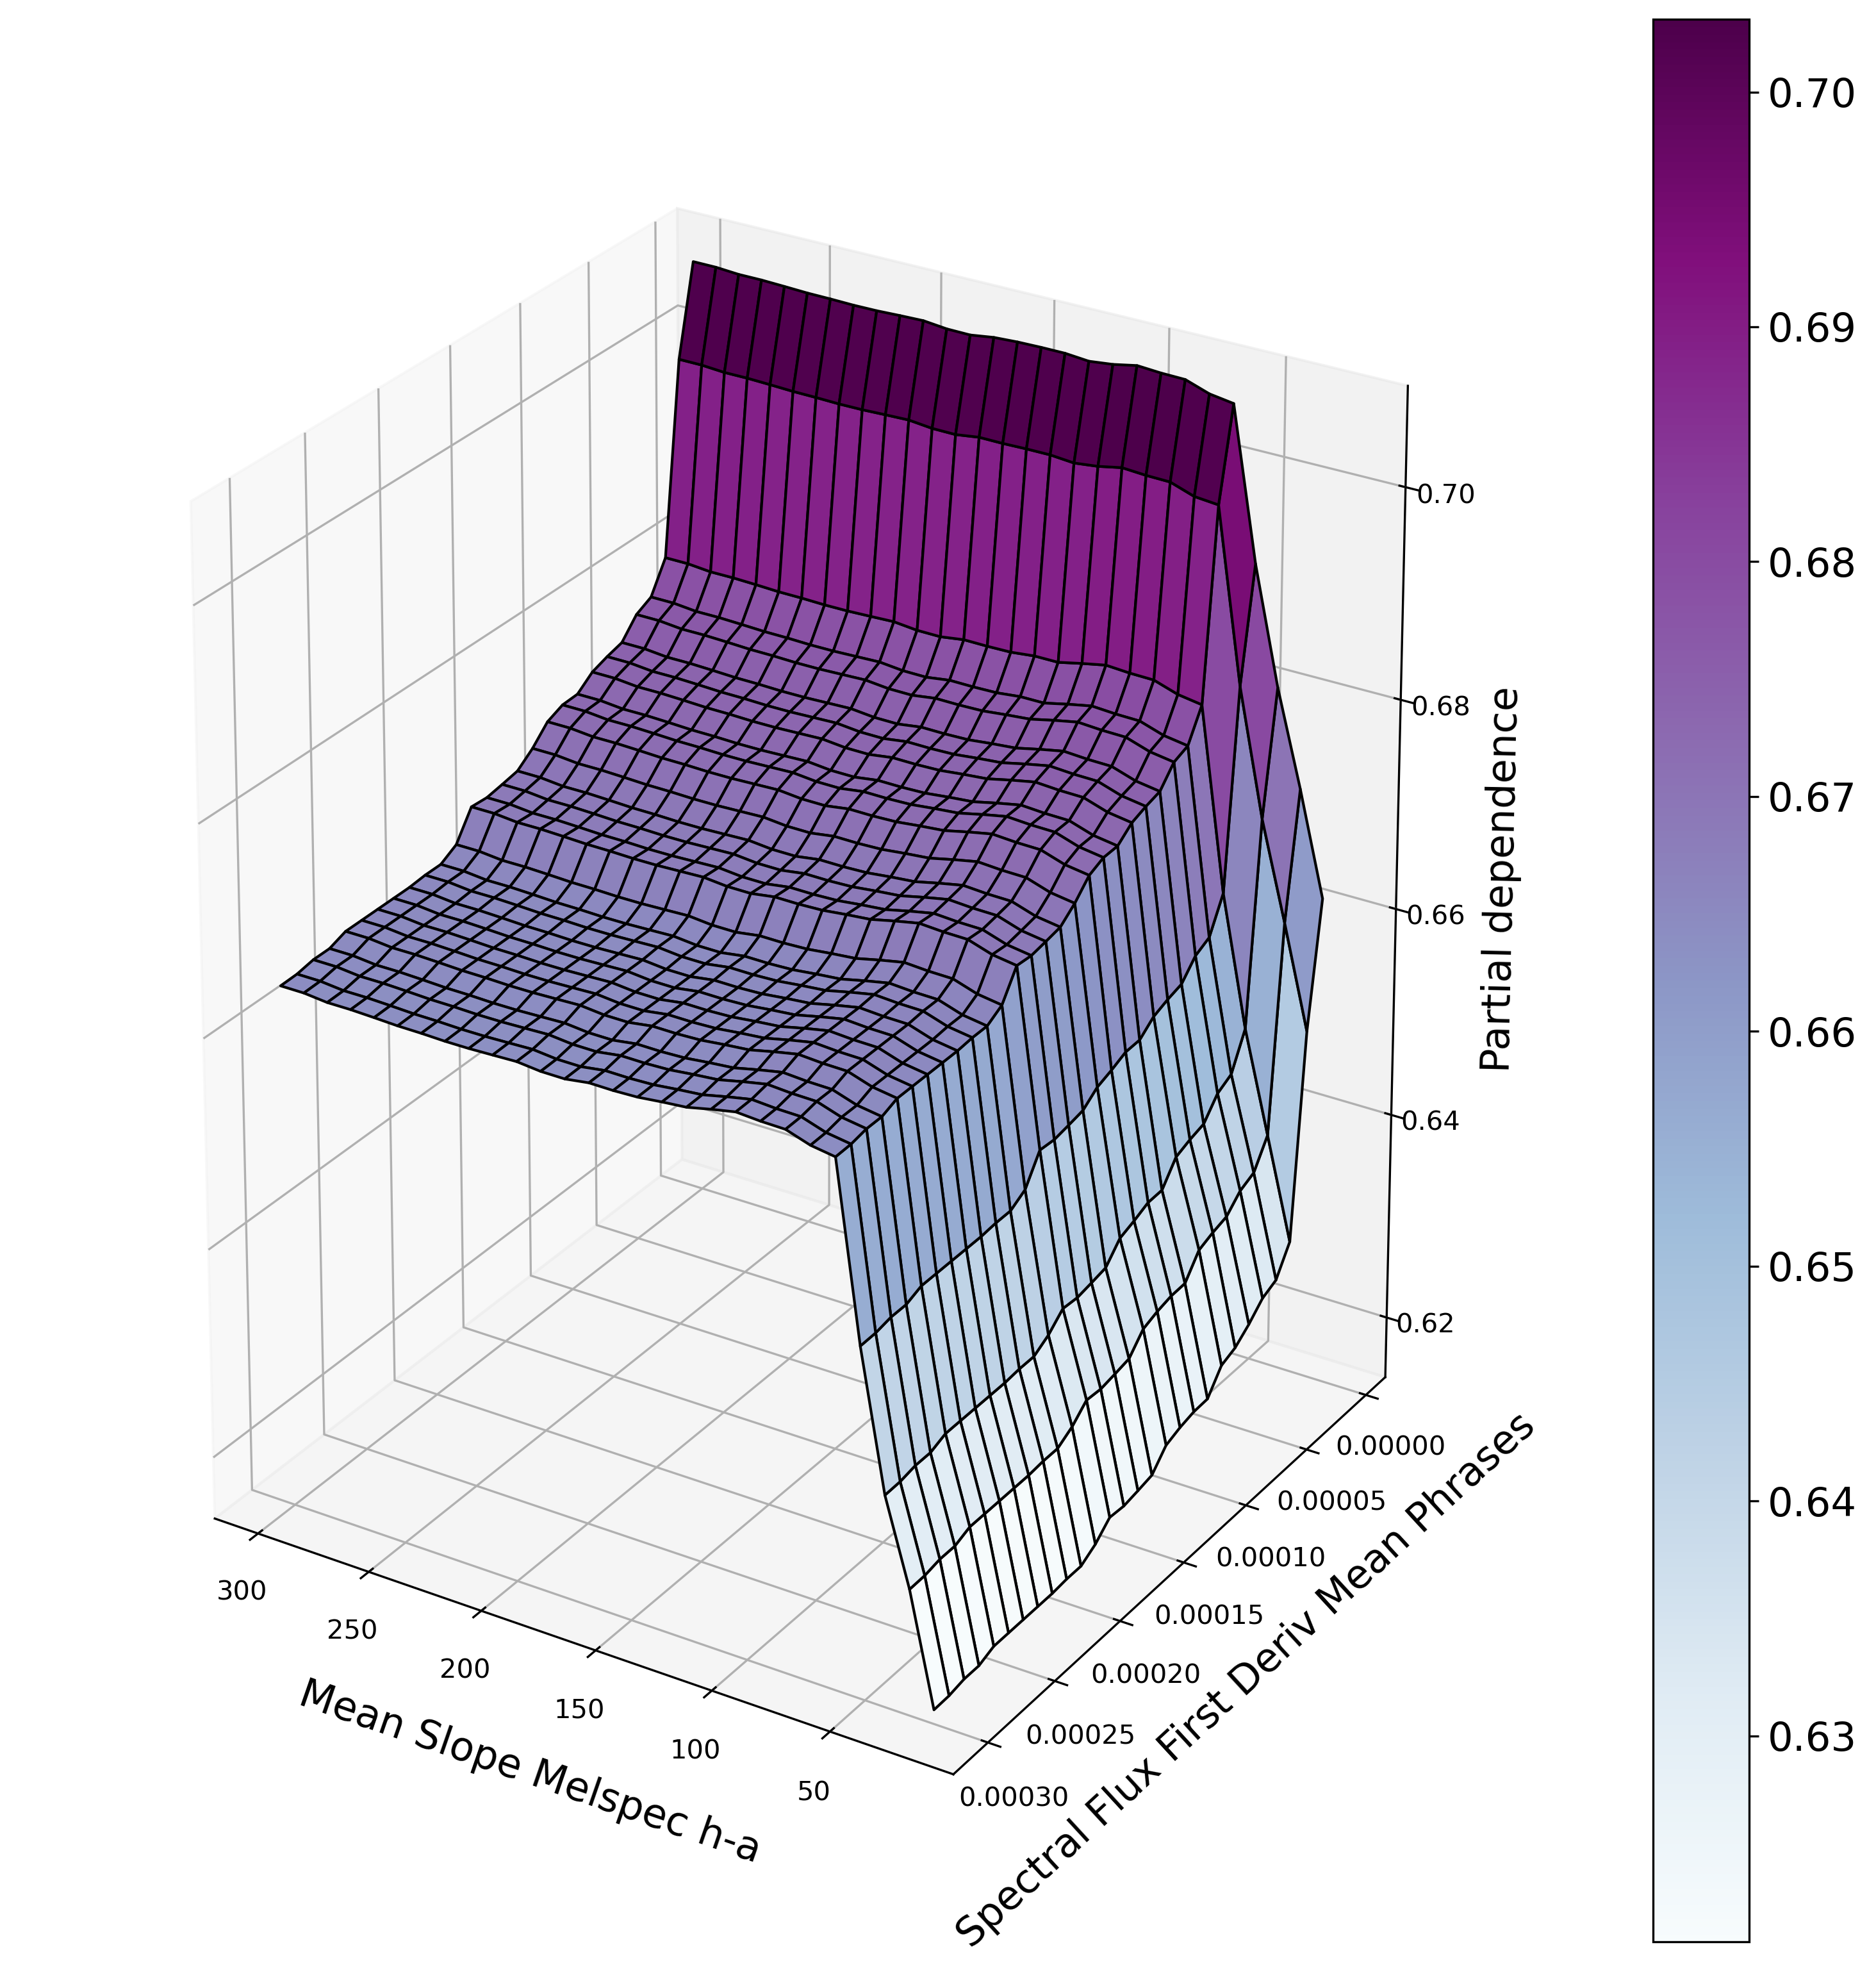

In [21]:
from sklearn.inspection import partial_dependence, plot_partial_dependence
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
rcParams['font.size'] = 15
fig = plt.figure()

features = ('Mean Slope Melspec h-a', 'Spectral Flux First Deriv Mean Phrases')
pdp = partial_dependence(
    tuned_clf, X_test, kind = 'average', features=features, grid_resolution=28
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0], labelpad = 10)
ax.set_ylabel(features[1], labelpad = 10)
ax.set_zlabel('Partial dependence', labelpad = 10)

ax.view_init(elev=22, azim=122)
plt.colorbar(surf)

plt.subplots_adjust(top=0.9)
plt.show()

#### Evaluate performance of the classifier across demographics variables. Note: Only subsets that included at least 20 instances were kept for this analysis.

In [22]:
X = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\Complete_Feature_Set_11_19_2.csv')
y, age, sex, recording_num = X['y'], X['age'], X['sex'], X['recording_num']
X = X.drop(['recording_num','y'], axis = 1)

rfecv_subset = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\RFECV_Results_12_8.csv')
X = X.loc[:, rfecv_subset.columns]

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X = X.drop(X[to_drop], axis=1)
X = X.drop('high_indexphrase_features', axis = 1)
print('Total number of features dropped was...', num_feats_after - X.shape[1], '\nRemaining features... ', X.shape[1])

X = pd.concat([X, sex, age], axis = 1)

Total number of features dropped was... 30 
Remaining features...  74


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify = y, random_state = 42)

mask_s0 = (X_test['sex'] == 0)
mask_s1 = (X_test['sex'] == 1)

mask_s0_age_1 = ((X_test['sex'] == 0) & (X_test['age'] == 1)) 
mask_s0_age_2 = ((X_test['sex'] == 0) & (X_test['age'] == 2))
mask_s0_age_3 = ((X_test['sex'] == 0) & (X_test['age'] == 3))
mask_s0_age_4 = ((X_test['sex'] == 0) & (X_test['age'] == 4))
mask_s0_age_5 = ((X_test['sex'] == 0) & (X_test['age'] == 5))
mask_s0_age_6 = ((X_test['sex'] == 0) & (X_test['age'] == 6))
mask_s0_age_7 = ((X_test['sex'] == 0) & (X_test['age'] == 7))

mask_s1_age_2 = ((X_test['sex'] == 1) & (X_test['age'] == 2))
mask_s1_age_3 = ((X_test['sex'] == 1) & (X_test['age'] == 3))
mask_s1_age_4 = ((X_test['sex'] == 1) & (X_test['age'] == 4))
mask_s1_age_5 = ((X_test['sex'] == 1) & (X_test['age'] == 5))
mask_s1_age_6 = ((X_test['sex'] == 1) & (X_test['age'] == 6))
mask_s1_age_7 = ((X_test['sex'] == 1) & (X_test['age'] == 7))

X_train = X_train.drop(['sex','age'], axis = 1)
X_test = X_test.drop(['sex','age'], axis = 1)

In [24]:
print('sex: F, age: 10-19\n', classification_report(y_test[mask_s0_age_1], tuned_clf.predict(X_test[mask_s0_age_1]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_1], tuned_clf.predict(X_test[mask_s0_age_1])))

sex: F, age: 10-19
               precision    recall  f1-score   support

      benign     0.9474    0.6923    0.8000        26
   anomalous     0.2000    0.6667    0.3077         3

    accuracy                         0.6897        29
   macro avg     0.5737    0.6795    0.5538        29
weighted avg     0.8701    0.6897    0.7491        29

0.6794871794871794


In [25]:
print('sex: F, age: 20-29\n', classification_report(y_test[mask_s0_age_2], tuned_clf.predict(X_test[mask_s0_age_2]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_2], tuned_clf.predict(X_test[mask_s0_age_2])))

sex: F, age: 20-29
               precision    recall  f1-score   support

      benign     0.8068    0.7978    0.8023        89
   anomalous     0.4857    0.5000    0.4928        34

    accuracy                         0.7154       123
   macro avg     0.6463    0.6489    0.6475       123
weighted avg     0.7181    0.7154    0.7167       123

0.648876404494382


In [26]:
print('sex: F, age: 30-39\n', classification_report(y_test[mask_s0_age_3], tuned_clf.predict(X_test[mask_s0_age_3]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_3], tuned_clf.predict(X_test[mask_s0_age_3])))

sex: F, age: 30-39
               precision    recall  f1-score   support

      benign     0.3750    0.5000    0.4286         6
   anomalous     0.9143    0.8649    0.8889        37

    accuracy                         0.8140        43
   macro avg     0.6446    0.6824    0.6587        43
weighted avg     0.8390    0.8140    0.8247        43

0.6824324324324325


In [27]:
print('sex: F, age: 40-49\n', classification_report(y_test[mask_s0_age_4], tuned_clf.predict(X_test[mask_s0_age_4]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_4], tuned_clf.predict(X_test[mask_s0_age_4])))

sex: F, age: 40-49
               precision    recall  f1-score   support

      benign     0.1429    0.2500    0.1818         4
   anomalous     0.9143    0.8421    0.8767        38

    accuracy                         0.7857        42
   macro avg     0.5286    0.5461    0.5293        42
weighted avg     0.8408    0.7857    0.8105        42

0.5460526315789473


In [28]:
print('sex: F, age: 50-59\n', classification_report(y_test[mask_s0_age_5], tuned_clf.predict(X_test[mask_s0_age_5]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_5], tuned_clf.predict(X_test[mask_s0_age_5])))

sex: F, age: 50-59
               precision    recall  f1-score   support

      benign     0.6667    0.5000    0.5714         4
   anomalous     0.9592    0.9792    0.9691        48

    accuracy                         0.9423        52
   macro avg     0.8129    0.7396    0.7703        52
weighted avg     0.9367    0.9423    0.9385        52

0.7395833333333333


In [29]:
print('sex: F, age: 60-69\n', classification_report(y_test[mask_s0_age_6], tuned_clf.predict(X_test[mask_s0_age_6]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_6], tuned_clf.predict(X_test[mask_s0_age_6])))

sex: F, age: 60-69
               precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         1
   anomalous     0.9750    0.9750    0.9750        40

    accuracy                         0.9512        41
   macro avg     0.4875    0.4875    0.4875        41
weighted avg     0.9512    0.9512    0.9512        41

0.4875


In [30]:
print('sex: F, age: 70-79\n', classification_report(y_test[mask_s0_age_7], tuned_clf.predict(X_test[mask_s0_age_7]), target_names = ['anomalous'], digits = 4))

sex: F, age: 70-79
               precision    recall  f1-score   support

   anomalous     1.0000    1.0000    1.0000        23

    accuracy                         1.0000        23
   macro avg     1.0000    1.0000    1.0000        23
weighted avg     1.0000    1.0000    1.0000        23



In [31]:
print('sex: M, age: 20-29\n', classification_report(y_test[mask_s1_age_2], tuned_clf.predict(X_test[mask_s1_age_2]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_2], tuned_clf.predict(X_test[mask_s1_age_2])))

sex: M, age: 20-29
               precision    recall  f1-score   support

      benign     0.8571    0.5333    0.6575        45
   anomalous     0.1600    0.5000    0.2424         8

    accuracy                         0.5283        53
   macro avg     0.5086    0.5167    0.4500        53
weighted avg     0.7519    0.5283    0.5949        53

0.5166666666666667


In [32]:
print('sex: M, age: 30-39\n', classification_report(y_test[mask_s1_age_3], tuned_clf.predict(X_test[mask_s1_age_3]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_3], tuned_clf.predict(X_test[mask_s1_age_3])))

sex: M, age: 30-39
               precision    recall  f1-score   support

      benign     0.8182    0.6429    0.7200        14
   anomalous     0.7500    0.8824    0.8108        17

    accuracy                         0.7742        31
   macro avg     0.7841    0.7626    0.7654        31
weighted avg     0.7808    0.7742    0.7698        31

0.7626050420168067


In [33]:
print('sex: M, age: 40-49\n', classification_report(y_test[mask_s1_age_4], tuned_clf.predict(X_test[mask_s1_age_4]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_4], tuned_clf.predict(X_test[mask_s1_age_4])))

sex: M, age: 40-49
               precision    recall  f1-score   support

      benign     0.4000    0.3333    0.3636         6
   anomalous     0.8462    0.8800    0.8627        25

    accuracy                         0.7742        31
   macro avg     0.6231    0.6067    0.6132        31
weighted avg     0.7598    0.7742    0.7661        31

0.6066666666666667


In [34]:
print('sex: M, age: 50-59\n', classification_report(y_test[mask_s1_age_5], tuned_clf.predict(X_test[mask_s1_age_5]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_5], tuned_clf.predict(X_test[mask_s1_age_5])))

sex: M, age: 50-59
               precision    recall  f1-score   support

      benign     0.6667    0.4000    0.5000         5
   anomalous     0.9423    0.9800    0.9608        50

    accuracy                         0.9273        55
   macro avg     0.8045    0.6900    0.7304        55
weighted avg     0.9172    0.9273    0.9189        55

0.69


In [35]:
print('sex: M, age: 60-69\n', classification_report(y_test[mask_s1_age_6], tuned_clf.predict(X_test[mask_s1_age_6]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_6], tuned_clf.predict(X_test[mask_s1_age_6])))

sex: M, age: 60-69
               precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         2
   anomalous     0.9615    1.0000    0.9804        50

    accuracy                         0.9615        52
   macro avg     0.4808    0.5000    0.4902        52
weighted avg     0.9246    0.9615    0.9427        52

0.5


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [36]:
print('sex: M, age: 70-79, note: only 1 class has support\n', classification_report(y_test[mask_s1_age_7], tuned_clf.predict(X_test[mask_s1_age_7], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_7], tuned_clf.predict(X_test[mask_s1_age_7])))

SyntaxError: invalid syntax (<ipython-input-36-307bd94aa42f>, line 2)

In [37]:
print('sex: F\n', classification_report(y_test[mask_s0], tuned_clf.predict(X_test[mask_s0]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0], tuned_clf.predict(X_test[mask_s0])))

sex: F
               precision    recall  f1-score   support

      benign     0.7540    0.7252    0.7393       131
   anomalous     0.8428    0.8616    0.8521       224

    accuracy                         0.8113       355
   macro avg     0.7984    0.7934    0.7957       355
weighted avg     0.8100    0.8113    0.8105       355

0.7933989912758997


In [39]:
print('sex: M\n', classification_report(y_test[mask_s1], tuned_clf.predict(X_test[mask_s1]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1], tuned_clf.predict(X_test[mask_s1])))

sex: M
               precision    recall  f1-score   support

      benign     0.7843    0.5333    0.6349        75
   anomalous     0.8301    0.9396    0.8814       182

    accuracy                         0.8210       257
   macro avg     0.8072    0.7364    0.7582       257
weighted avg     0.8167    0.8210    0.8095       257

0.7364468864468864


### Pickle the model for later use.

In [40]:
pkl_filename = "RF_1_25_.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(tuned_clf, file)